# Telemetry Plotly Notebook

Interactive plots for telemetry.jsonl with millisecond timestamps.

- Use event timestamps (event_ts_ms.* / *.ts_ms)
- Supports two-run comparison


In [2]:
from pathlib import Path
import sys
import pandas as pd
import plotly.graph_objects as go

# Make project importable
cwd = Path.cwd()
if (cwd / 'src').exists():
    ROOT = cwd
elif (cwd.parent / 'src').exists():
    ROOT = cwd.parent
else:
    ROOT = Path.cwd()

sys.path.insert(0, str(ROOT / 'src'))

from plotting.io import load_jsonl, filter_records
from plotting.processing import normalize_records, maybe_downsample

pd.set_option('display.max_columns', 200)


In [3]:
# ---- Configuration ----
INPUT = Path('/home/maxim140/RustroverProjects/btc-15m-trading-bot/output/json/markets/btc-updown-15m-1767768300/telemetry.jsonl')
STRATEGY = 'telemetry'
MARKET = None  # or 'btc-updown-15m-...'
DOWNSAMPLE_RULE = '50ms'  # use None for raw
MAX_POINTS = 500_000


In [4]:
def _ms_series(df: pd.DataFrame, columns):
    for col in columns:
        if col in df.columns:
            s = pd.to_numeric(df[col], errors='coerce')
            if s.notna().any():
                return s
    return None

def _ms_to_dt(series: pd.Series):
    return pd.to_datetime(series, unit='ms', utc=True, errors='coerce')

def select_time_series(df: pd.DataFrame, source='event'):
    if source == 'log':
        if 'timestamp' in df.columns:
            return df['timestamp']
        if 'event_ts_ms.log' in df.columns:
            return _ms_to_dt(pd.to_numeric(df['event_ts_ms.log'], errors='coerce'))
        return pd.Series([pd.NaT] * len(df), index=df.index)

    if source == 'btc':
        s = _ms_series(df, ('event_ts_ms.btc', 'btc.ts_ms', 'telemetry_state.btc.last_sample.ts_ms'))
        if s is not None:
            return _ms_to_dt(s)
        return select_time_series(df, 'log')

    if source == 'up_book':
        s = _ms_series(df, ('event_ts_ms.book_up', 'up_l1.ts_ms', 'telemetry_state.book.up.last_sample.ts_ms'))
        if s is not None:
            return _ms_to_dt(s)
        return select_time_series(df, 'log')

    if source == 'down_book':
        s = _ms_series(df, ('event_ts_ms.book_down', 'down_l1.ts_ms', 'telemetry_state.book.down.last_sample.ts_ms'))
        if s is not None:
            return _ms_to_dt(s)
        return select_time_series(df, 'log')

    if source in {'book', 'event'}:
        book_direct = _ms_series(df, ('event_ts_ms.book',))
        up_ms = _ms_series(df, ('event_ts_ms.book_up', 'up_l1.ts_ms', 'telemetry_state.book.up.last_sample.ts_ms'))
        down_ms = _ms_series(df, ('event_ts_ms.book_down', 'down_l1.ts_ms', 'telemetry_state.book.down.last_sample.ts_ms'))
        btc_ms = _ms_series(df, ('event_ts_ms.btc', 'btc.ts_ms', 'telemetry_state.btc.last_sample.ts_ms'))

        if book_direct is not None:
            book_ms = book_direct
        else:
            frames = []
            if up_ms is not None:
                frames.append(up_ms)
            if down_ms is not None:
                frames.append(down_ms)
            book_ms = pd.concat(frames, axis=1).max(axis=1, skipna=True) if frames else None

        if source == 'book':
            if book_ms is not None and book_ms.notna().any():
                return _ms_to_dt(book_ms)
            if btc_ms is not None:
                return _ms_to_dt(btc_ms)
            return select_time_series(df, 'log')

        frames = []
        if book_ms is not None:
            frames.append(book_ms)
        if btc_ms is not None:
            frames.append(btc_ms)
        if frames:
            return _ms_to_dt(pd.concat(frames, axis=1).max(axis=1, skipna=True))
        return select_time_series(df, 'log')

    return select_time_series(df, 'log')

def base_time(df: pd.DataFrame):
    candidates = []
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce')
        if ts.notna().any():
            candidates.append(ts)
    for col in (
        'ts_ms', 'event_ts_ms.log', 'event_ts_ms.btc', 'event_ts_ms.book_up',
        'event_ts_ms.book_down', 'event_ts_ms.book', 'btc.ts_ms',
        'telemetry_state.btc.last_sample.ts_ms', 'up_l1.ts_ms', 'down_l1.ts_ms',
        'telemetry_state.book.up.last_sample.ts_ms',
        'telemetry_state.book.down.last_sample.ts_ms'
    ):
        if col in df.columns:
            s = pd.to_numeric(df[col], errors='coerce')
            if s.notna().any():
                candidates.append(_ms_to_dt(s))
    if not candidates:
        return None
    base = pd.concat(candidates, axis=1).min().min()
    if pd.isna(base):
        return None
    if getattr(base, 'tzinfo', None) is not None:
        base = base.tz_convert(None)
    return base

def elapsed_seconds(series: pd.Series, base=None):
    ts = pd.to_datetime(series, errors='coerce')
    if not ts.notna().any():
        return pd.Series([float('nan')] * len(ts), index=ts.index)
    if getattr(ts.dtype, 'tz', None) is not None and ts.dt.tz is not None:
        ts = ts.dt.tz_convert(None)
    if base is not None and getattr(base, 'tzinfo', None) is not None:
        base = base.tz_convert(None)
    if base is None:
        base = ts.min()
    return (ts - base).dt.total_seconds()


In [5]:
records = load_jsonl(INPUT)
filtered = filter_records(records, strategy=STRATEGY, market_slug=MARKET)
df = normalize_records(filtered)
df = maybe_downsample(df, rule=DOWNSAMPLE_RULE, max_points=MAX_POINTS)
df.head()


,open_orders,skew_up_down,strategy,ts_ms,btc.basis_start,btc.basis_start_ts_ms,btc.delta,btc.delta_pct,btc.fair_gap_down,btc.fair_gap_up,btc.history_len,btc.history_span_ms,btc.p_fair_down,btc.p_fair_up,btc.price,btc.price_to_beat,btc.r1,btc.r10,btc.r2,btc.r5,btc.shock_impulse_2sigma,btc.sigma_long,btc.sigma_short,btc.tau_s,btc.ts_ms,btc.z_delta,btc.z_impulse_r1,btc.z_log,down_depth.levels,down_depth.tick,down_depth.ts_ms,down_l1.ask_liquidity,down_l1.ask_p,down_l1.ask_q,down_l1.bid_liquidity,down_l1.bid_p,down_l1.bid_q,down_l1.imbalance,down_l1.micro,down_l1.micro_mid_gap,down_l1.mid,down_l1.normalized_spread,down_l1.spread,down_l1.tick,down_l1.ts_ms,event_ts_ms.book,event_ts_ms.book_down,event_ts_ms.book_up,event_ts_ms.btc,event_ts_ms.log,event_ts_ms.price_sources.polymarket_rtds_chainlink,event_ts_ms.price_sources.tiingo,history_metrics.corr_micro_btc_20s,history_metrics.corr_micro_btc_60s,history_metrics.cross_k.cross_down_1s,history_metrics.cross_k.cross_up_1s,history_metrics.down.btc_delta_1s,history_metrics.down.btc_delta_2s,history_metrics.down.distance_to_k,history_metrics.down.micro_delta_1s,history_metrics.down.micro_delta_250ms,history_metrics.down.micro_delta_2s,history_metrics.down.micro_delta_500ms,history_metrics.down.micro_r_0p5s,history_metrics.down.micro_r_1s,history_metrics.down.micro_r_2s,history_metrics.down.mid_r_0p5s,history_metrics.down.mid_r_1s,history_metrics.down.mid_r_2s,history_metrics.down.slope_mid_1s,history_metrics.down.slope_mid_2s,history_metrics.down.slope_mid_5s,history_metrics.down.spread_std_30s,history_metrics.down.spread_std_5s,history_metrics.up.btc_delta_1s,history_metrics.up.btc_delta_2s,history_metrics.up.distance_to_k,history_metrics.up.micro_delta_1s,history_metrics.up.micro_delta_250ms,history_metrics.up.micro_delta_2s,history_metrics.up.micro_delta_500ms,history_metrics.up.micro_r_0p5s,history_metrics.up.micro_r_1s,history_metrics.up.micro_r_2s,history_metrics.up.mid_r_0p5s,history_metrics.up.mid_r_1s,history_metrics.up.mid_r_2s,history_metrics.up.slope_mid_1s,history_metrics.up.slope_mid_2s,history_metrics.up.slope_mid_5s,history_metrics.up.spread_std_30s,history_metrics.up.spread_std_5s,market.end_ms,market.remaining_ms,market.slug,market.start_ms,open_orders_stats.buy_down,open_orders_stats.buy_up,open_orders_stats.count,open_orders_stats.sell_down,...,shock.move_5s,shock.shock_mode,shock.shock_ratio,strategy_state.cooldown_until_ms,strategy_state.last_entry_ts_ms,strategy_state.last_exit_ts_ms,strategy_state.last_flip_ts_ms,strategy_state.last_side,strategy_state.min_hold_until_ms,telemetry_state.book.down.best_ask_changes_1s,telemetry_state.book.down.best_bid_changes_1s,telemetry_state.book.down.deltas_60s,telemetry_state.book.down.events_1s,telemetry_state.book.down.events_5s,telemetry_state.book.down.last_event_ts_ms,telemetry_state.book.down.last_sample.ask_liquidity,telemetry_state.book.down.last_sample.ask_p,telemetry_state.book.down.last_sample.ask_q,telemetry_state.book.down.last_sample.bid_liquidity,telemetry_state.book.down.last_sample.bid_p,telemetry_state.book.down.last_sample.bid_q,telemetry_state.book.down.last_sample.imbalance,telemetry_state.book.down.last_sample.micro,telemetry_state.book.down.last_sample.mid,telemetry_state.book.down.last_sample.spread,telemetry_state.book.down.last_sample.ts_ms,telemetry_state.book.down.samples,telemetry_state.book.down.snapshots_60s,telemetry_state.book.up.best_ask_changes_1s,telemetry_state.book.up.best_bid_changes_1s,telemetry_state.book.up.deltas_60s,telemetry_state.book.up.events_1s,telemetry_state.book.up.events_5s,telemetry_state.book.up.last_event_ts_ms,telemetry_state.book.up.last_sample.ask_liquidity,telemetry_state.book.up.last_sample.ask_p,telemetry_state.book.up.last_sample.ask_q,telemetry_state.book.up.last_sample.bid_liquidity,telemetry_state.book.up.last_sample.bid_p,telemetry_state.book.up.last_sample.bid_q,telemetry_state.book.up.last_sample.imbalance,telemetry_state.book.up.last_sample.micro,telemetry_s

In [6]:
def plot_lines(df, columns, title, time_source='event', yaxis_title='value', yaxis_range=None):
    ts = select_time_series(df, time_source)
    base = base_time(df)
    x = elapsed_seconds(ts, base)

    fig = go.Figure()
    for col in columns:
        if col in df.columns:
            fig.add_trace(go.Scatter(
                x=x,
                y=pd.to_numeric(df[col], errors='coerce'),
                mode='lines',
                name=col
            ))

    fig.update_layout(
        title=title,
        xaxis_title='seconds',
        yaxis_title=yaxis_title,
        hovermode='x unified',
        height=500
    )
    fig.update_xaxes(showgrid=True, dtick=5, ticks='outside')
    fig.update_yaxes(showgrid=True)
    if yaxis_range is not None:
        fig.update_yaxes(range=yaxis_range)
    return fig

def plot_book_side(df, side='up'):
    cols = [f'{side}_l1.bid_p', f'{side}_l1.ask_p', f'{side}_l1.mid']
    fig = plot_lines(df, cols, f'{side.upper()} L1 bid/ask', time_source=f'{side}_book', yaxis_title='price')
    fig.update_yaxes(range=[0, 1], dtick=0.1, tickformat='.2f')
    return fig

def compare_runs(df_a, df_b, columns, title, time_source='event', labels=('A', 'B')):
    base_a = base_time(df_a)
    base_b = base_time(df_b)
    x_a = elapsed_seconds(select_time_series(df_a, time_source), base_a)
    x_b = elapsed_seconds(select_time_series(df_b, time_source), base_b)

    fig = go.Figure()
    for col in columns:
        if col in df_a.columns:
            fig.add_trace(go.Scatter(
                x=x_a, y=pd.to_numeric(df_a[col], errors='coerce'),
                mode='lines', name=f'{labels[0]}:{col}'
            ))
        if col in df_b.columns:
            fig.add_trace(go.Scatter(
                x=x_b, y=pd.to_numeric(df_b[col], errors='coerce'),
                mode='lines', name=f'{labels[1]}:{col}', line=dict(dash='dash')
            ))

    fig.update_layout(title=title, xaxis_title='seconds', hovermode='x unified', height=500)
    fig.update_xaxes(showgrid=True, dtick=5)
    fig.update_yaxes(showgrid=True)
    return fig


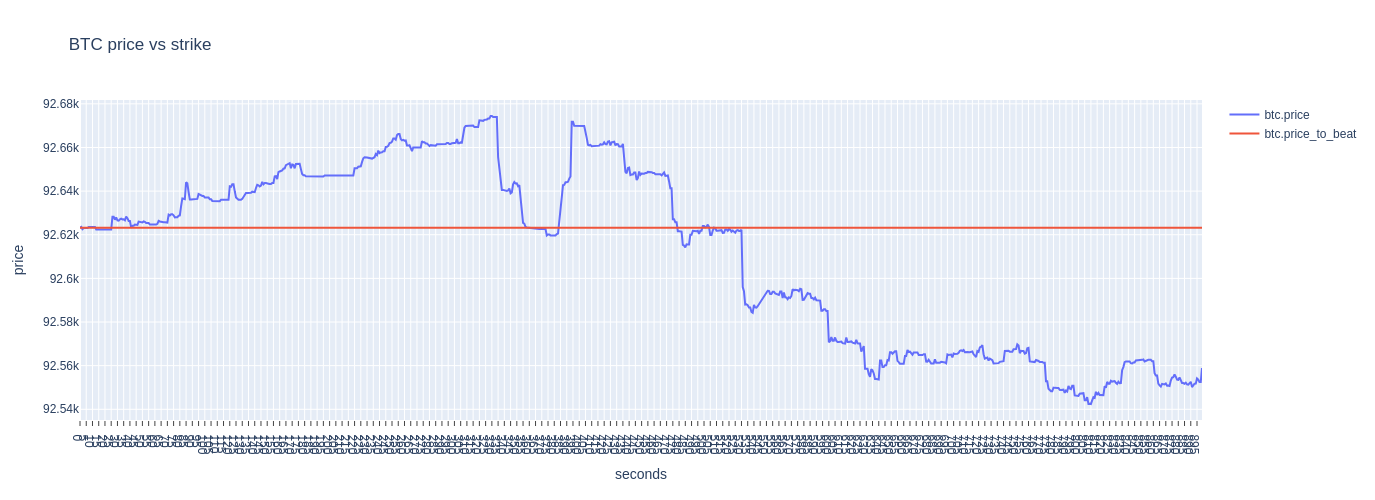

In [7]:
# Examples
plot_lines(df, ['btc.price', 'btc.price_to_beat'], 'BTC price vs strike', time_source='btc', yaxis_title='price')


plot_lines(df, ['btc.p_fair_up', 'btc.p_fair_down'], 'Fair probabilities', time_source='btc', yaxis_title='probability', yaxis_range=[0,1])


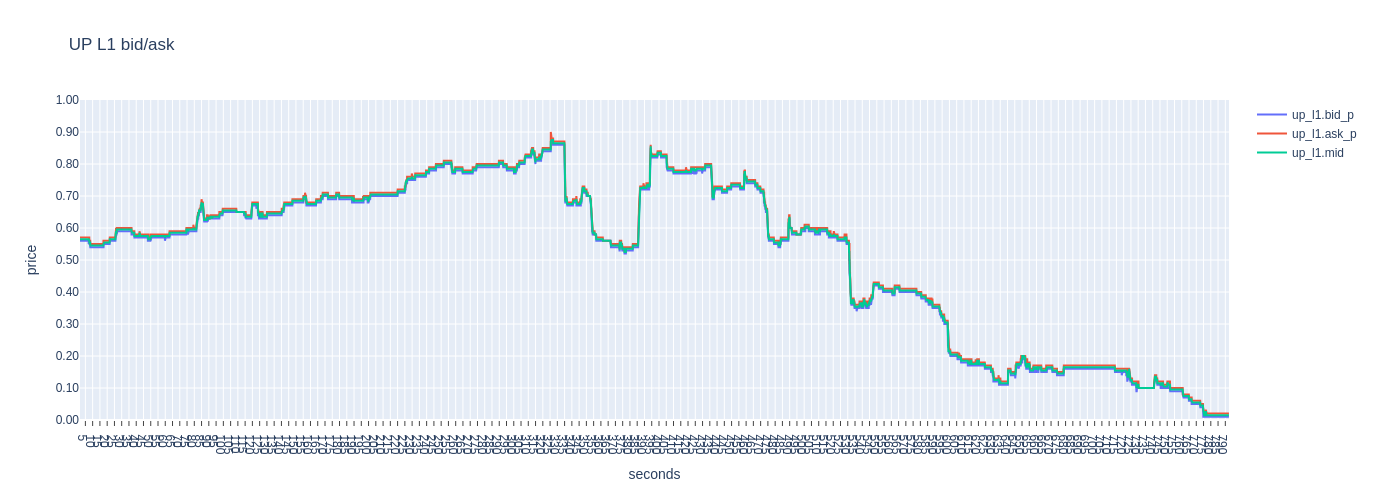

In [9]:
plot_book_side(df, side='up')


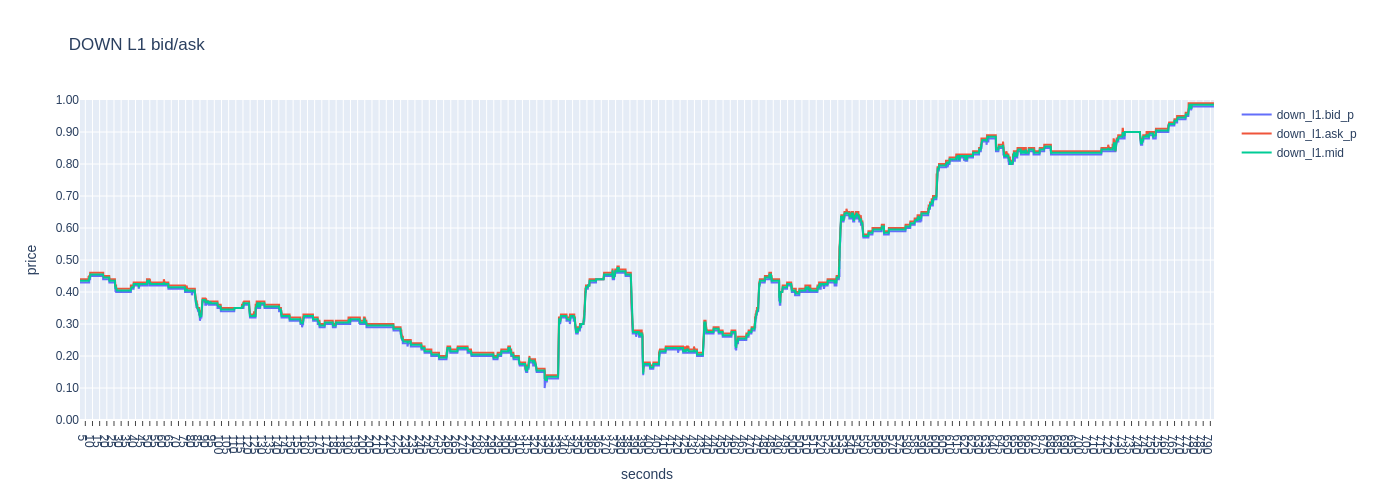

In [10]:
plot_book_side(df, side='down')
